In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"]
N_x = Params["N_x"]
c_l = Params["c_l"]
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"]
S_train = Params["S_train"]
S_test = Params["S_test"]
m = Params["m"]
N_nonzero = Params["N_nonzero"]
Time_Limit = Params["Time_Limit"]
dual_norm = Params["dual_norm"]
gamma_list = Params["gamma_list"]
psi_lb = Params["psi_lb"]
psi_ub = Params["psi_ub"]
phi_lb = Params["phi_lb"]
phi_ub = Params["phi_ub"]
num_c = Params["num_c"]
instances = Params["instances"]
seed = Params["seed"]
coef_this = Params["coef_this"]
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"]

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = false;
is_same_util_para = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    coef_para_Input = coef_this;
    project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_S_train=$(S_train)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_para_Input);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design/")
data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=1_Same_Util_Para/


In [ ]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

### Lambda = 0.01

In [ ]:
lambda = 0.01
Input_Data = Dict()
RST_True_All = Dict()
RST_ETO_All = Dict()
RST_RO_All = Dict()
ins = 1
while ins <= instances
    if is_same_util_para
        Input_Data_this = Generate_Data_this_Same_Para(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input,theta_true_Fixed, r_params_Fixed)
    else
        Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
    end
    theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)
    Input_Data["ins=$(ins)"] = Input_Data_this
    nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
    nu_all_true = [nu0_true;nu_true]

    theta_Input = theta_true
    RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
    if status_True != "OPTIMAL"
        println("Warning: The true model did not reach optimality")
        continue
    end
    RST_True_All["ins=$(ins)"] = RST_True

    theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
    nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
    nu_all_hat = [nu0_hat;nu_hat]
    if any(isnan, nu_all_hat) || norm(vec(nu_all_true .- nu_all_hat),2) >= 10
        println("Estimate contains NaN values or is too far from true parameters.")
        continue
    end

    RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
    if status_ETO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    RST_ETO_All["ins=$(ins)"] = RST_ETO
    
    RST_RO_this = Dict()
    gamma = gamma_list[1]
    RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
    if status_RO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
        println("Warning: The RO profit is not equivalent to ETO profit")
        continue
    end
    RST_RO_this[string("gamma=",gamma)] = RST_RO

    for g_index in 2:length(gamma_list)
        gamma = gamma_list[g_index]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        RST_RO_this[string("gamma=",gamma)] = RST_RO
    end
    RST_RO_All["ins=$(ins)"] = RST_RO_this
    println("******* ins = ",ins,"*********")
    ins = ins + 1
end
save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

In [ ]:
profit_True = zeros(instances);
profit_ETO = zeros(instances);
profit_RO = zeros(instances, length(gamma_list));
for ins in 1:instances
    profit_True[ins] = mean(RST_True_All["ins=$(ins)"]["profit"])
    profit_ETO[ins] = mean(RST_ETO_All["ins=$(ins)"]["profit"])
end
println("True profit: mean = ", mean(profit_True), ", std = ", std(profit_True))
println("ETO profit: mean = ", mean(profit_ETO), ", std = ", std(profit_ETO))

- Results

In [4]:
lambda = 0.01
Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [5]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0]


In [6]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:0.3573
profit ETO:0.3087
profit RO:[0.3087 0.3133 0.318 0.3222 0.3254 0.3248 0.3235 0.3205 0.3156]


- Line plot 

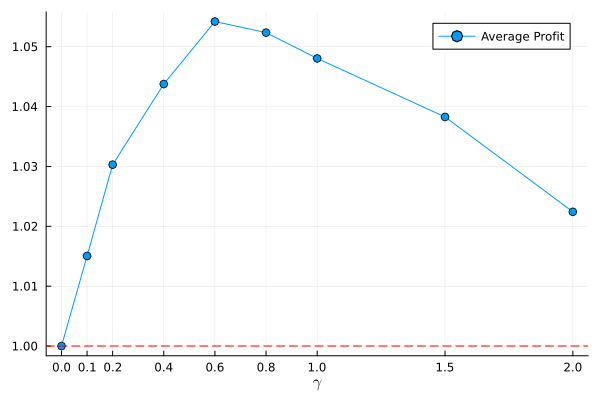

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=1_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.01.pdf"

In [7]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

- Boxplot

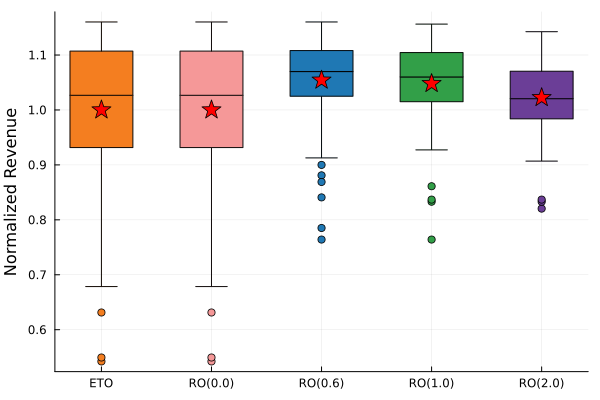

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Product_Line_Design/N=3_N_x=8_N_u=1_S_train=100_N_nonzero=5_dr=2.0_seed=1_Same_Util_Para/Boxplot_RPLD_vs_ETOPLD_lambda=0.01_Normalize.pdf"

In [8]:
Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO)
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
end

chosen_indices = [1,5,7,9]
gamma_chosen = gamma_list[chosen_indices]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$(lambda)_Normalize.pdf")
boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)

In [ ]:
gamma_index = length(gamma_list)
fig_name = string(data_dir, "RPLD_vs_ETOPLD_Distribution_lambda=$(lambda)_gamma=$(gamma_list[gamma_index]).pdf")
hist_profit_distribution(profit_ETO, profit_RO, gamma_index,gamma_list,fig_name)

# Lambda = 0.0

In [ ]:
lambda = 0.0
Input_Data = Dict()
RST_True_All = Dict()
RST_ETO_All = Dict()
RST_RO_All = Dict()
ins = 1
while ins <= instances
    if is_same_util_para
        Input_Data_this = Generate_Data_this_Same_Para(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input,theta_true_Fixed, r_params_Fixed)
    else
        Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
    end
    theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)
    Input_Data["ins=$(ins)"] = Input_Data_this
    nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
    nu_all_true = [nu0_true;nu_true]

    theta_Input = theta_true
    RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
    if status_True != "OPTIMAL"
        println("Warning: The true model did not reach optimality")
        continue
    end
    RST_True_All["ins=$(ins)"] = RST_True

    theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
    nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
    nu_all_hat = [nu0_hat;nu_hat]
    if any(isnan, nu_all_hat) || norm(vec(nu_all_true .- nu_all_hat),2) >= 10
        println("Estimate contains NaN values or is too far from true parameters.")
        continue
    end

    RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
    # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
    if status_ETO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    RST_ETO_All["ins=$(ins)"] = RST_ETO
    
    RST_RO_this = Dict()
    gamma = gamma_list[1]
    RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
    # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
    if status_RO != "OPTIMAL"
        println("Warning: The ETO model did not reach optimality")
        continue
    end
    if abs(RST_RO["profit"][1] - RST_ETO["profit"][1]) > 1e-4
        println("Warning: The RO profit is not equivalent to ETO profit")
        continue
    end
    RST_RO_this[string("gamma=",gamma)] = RST_RO

    for g_index in 2:length(gamma_list)
        gamma = gamma_list[g_index]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        RST_RO_this[string("gamma=",gamma)] = RST_RO
    end
    RST_RO_All["ins=$(ins)"] = RST_RO_this
    println("******* ins = ",ins,"*********")
    ins = ins + 1
end
save(string(data_dir, "Input_Data_lambda=$(lambda).jld2"), Input_Data);
save(string(data_dir, "RST_True_lambda=$(lambda).jld2"), RST_True_All);
save(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"), RST_ETO_All);
save(string(data_dir, "RST_RO_lambda=$(lambda).jld2"), RST_RO_All);

In [ ]:
lambda = 0.0
Input_Data = load(string(data_dir, "Input_Data_lambda=$(lambda).jld2"));
RST_True_All = load(string(data_dir, "RST_True_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_lambda=$(lambda).jld2"));

In [ ]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

In [ ]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

In [ ]:
Profit_ETO_All_Ins = profit_ETO
Profit_RO_All_Ins = Dict();
for g_index in 1:length(gamma_list)
    gamma=gamma_list[g_index]
    Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]
end

chosen_indices = [1,5,7,9]
gamma_chosen = gamma_list[chosen_indices]
data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$lambda.pdf")
boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)

In [ ]:
gamma_index = length(gamma_list)
fig_name = string(data_dir, "RPLD_vs_ETOPLD_Distribution_lambda=$(lambda)_gamma=$(gamma_list[gamma_index]).pdf")
hist_profit_distribution(profit_ETO, profit_RO, gamma_index,gamma_list,fig_name)

#### Wang_Qi_Max

In [ ]:
# lambda = 0.01

# Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_Wang_Qi_Shen)
# theta_true,r_params,X_train,Y_train,Z_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this)

# theta_Input = theta_true
# RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

# theta_hat = Estimation_This(lambda,X_train,Y_train,Z_train,N_x,N_u)
# RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)

In [ ]:
# nu0_true, nu_true = compute_w(theta_true,Z_test[1,:])
# nu0_hat, nu_hat = compute_w(theta_hat,Z_test[1,:])
# println("W true = ", round.([nu0_true; nu_true],digits=4))
# println("W hat  = ", round.([nu0_hat; nu_hat],digits=4))

In [ ]:
# println("Price coef = ",round.(r_params.r,digits=4))

In [ ]:
# RST_True["X"][1,:,:]

In [ ]:
# RST_ETO["X"][1,:,:]

In [ ]:
# price_true = RST_True["X"][1,:,:] * r_params.r
# price_eto = RST_ETO["X"][1,:,:] * r_params.r
# println("True Price = ", round.(price_true,digits=4))
# println("ETO  Price = ", round.(price_eto,digits=4))

In [ ]:
# util_true = nu0_true .+ RST_True["X"][1,:,:] * nu_true;
# exp_util_true = exp.(util_true);
# prob_util_true = exp_util_true ./ (1+sum(exp_util_true))

In [ ]:
# util_hat = nu0_hat .+ RST_ETO["X"][1,:,:] * nu_hat;
# exp_util_hat = exp.(util_hat);
# prob_util_hat = exp_util_hat ./ (1+sum(exp_util_hat))

In [ ]:
# println("True rev = ",prob_util_true' * price_true)
# println("True rev = ",prob_util_hat' * price_eto)

In [2]:
# file: expcone_logsum_example.jl
using Random
using LinearAlgebra
using JuMP
using MosekTools       # 接口到 MOSEK

In [7]:
# 随机示例数据（你可替换成自己的 A, a_n）
Random.seed!(2)
d = 3     # w 的维度
N = 5     # 备选项数量

A = randn(N, d)    # 每行是 a_j^T
a_n = A[1,:]

3-element Vector{Float64}:
 -1.4107270035180548
  1.2553734257251303
  2.1211993546237053

In [ ]:
# 创建模型并指定 MOSEK 求解器
model = Model(Mosek.Optimizer)
#（可选：设置求解器参数）
set_optimizer_attribute(model, "MSK_DPAR_INTPNT_TOL_REL_GAP", 1e-9)  # 示例：相对间隙容忍度
# 变量定义
@variable(model, w[1:d])            # w \in R^d
@variable(model, s[1:N+1])          
@variable(model, y[1:N+1])          
@variable(model, v)                 

@constraint(model, 1 >= sum(y))
for j in 1:N
    @constraint(model, [ A[j,:]' * w - v, 1.0, y[j]] in MOI.ExponentialCone())
end
@constraint(model, [ -v, 1.0, y[N+1] ] in MOI.ExponentialCone())

# 目标： maximize a_n^T w - v
@objective(model, Max, sum(a_n[i] * w[i] for i in 1:d) - v)

optimize!(model)

# 读取并打印结果
status = termination_status(model)
println("Termination status: ", status)
println("Objective value: ", objective_value(model))

v

In [28]:
w_opt = value.(w)
s_opt = value.(s)
y_opt = value.(y)
v_opt = value(v)

println("Optimal w:")
println(w_opt)
println("a_n' * w:",a_n' * w_opt)
println("A * w:",A * w_opt)
println("exp(1+sum(exp)):",log(sum(exp.(A * w_opt))+1))
# println(s_opt)
# println("\ny (aux) and exp(s):")
# for j in 1:N
#     println(" j=$j: y=", y_opt[j], "   exp(s)=", exp(s_opt[j]))
# end
println("v = ", v_opt)
# println("\nChecks (abs diffs):")
# println(" max|y - exp(s)| = ", maximum(abs.(y_opt .- exp.(s_opt))))


Optimal w:
[5.10133363137191, 3.5515640199420497, 11.324660572825211]
a_n' * w:21.283812681074956
A * w:[21.283812681074956, -0.37876564602924123, -1.5576201138158676, -3.2808436386619517, -3.514418086716456]
exp(1+sum(exp)):21.283812682195457
v = 21.28381270272631


In [39]:
round.(rand(d, 2) .* 1; digits=2)

3×2 Matrix{Float64}:
 0.41  0.94
 0.64  0.27
 0.1   0.45

In [61]:
K = 100  # 列数
w_mat = repeat(collect(LinRange(0, 12, K))', d, 1)

3×100 Matrix{Float64}:
 0.0  0.121212  0.242424  0.363636  …  11.6364  11.7576  11.8788  12.0
 0.0  0.121212  0.242424  0.363636     11.6364  11.7576  11.8788  12.0
 0.0  0.121212  0.242424  0.363636     11.6364  11.7576  11.8788  12.0

In [62]:
rev_opt = -100000
price_opt = zeros(N)

for i in 1:K
    p1 = w_mat[1,i]
    for j in 1:K
        p2 = w_mat[2,j]
        for l in 1:K
            p3 = w_mat[3,l]
            w_tem = [p1,p2,p3]
            rev_tem = a_n' * w_tem - log(1+sum(exp.(A * w_tem)))
            
            if rev_tem > rev_opt
                rev_opt = rev_tem
                price_opt = w_tem 
            end
        end
    end
end